A través de este código iremos estudiando los datos y buscando el mejor modelo para predecir la altura de la ola

# Lectura dataset

In [ ]:
import pandas as pd

# Leer el archivo CSV (separado por comas)
df = pd.read_csv('limpio.csv')

# Vista previa del DataFrame
df.head()


,Fecha (GMT),AlturaSignif.delOleaje(m),PeriodoMedio(s),Periodo_Pico,Direccion_Procedencia,Mardefondo1:Alturasignif.Espectral(m),Velocidad media de Corriente(m/s),"Dir. de prop. de la Corriente (0=N,90=E)",SOLAR PRESENCE,LUNAR PRESENCE,...,MN_Illu%,PsAng,PsAMV,Sky_motion,Sky_mot_PA,RelVel-ANG,Salinidad(psu),Temperatura del Agua(ºC),Velocidad del viento(m/s),"Direc. de proced. del Viento(0=N,90=E)"
0,2019-12-12 00:00:00,2.09,10.4,14.7,352.0,1.86,0.074,92.57,,m,...,99.9060,43.944,264.350,22.905428,74.381959,-4.531192,34.979,14.506,7.33,262.0
1,2019-12-12 01:00:00,2.16,11.2,14.7,353.0,1.94,0.067,92.53,,m,...,99.9207,41.045,264.487,22.947002,77.164054,1.803459,34.979,14.500,5.82,243.0
2,2019-12-12 02:00:00,2.23,11.4,14.7,353.0,2.01,0.063,92.42,,m,...,99.9334,37.211,264.630,23.724617,80.111940,7.457271,34.979,14.492,5.84,253.0
3,2019-12-12 03:00:00,2.27,11.3,14.7,353.0,2.04,0.060,92.21,,m,...,99.9442,32.059,264.783,25.186602,82.794879,11.610805,34.979,14.484,5.61,252.0
4,2019-12-12 04:00:00,2.28,11.5,14.7,353.0,2.06,0.058,91.96,,m,...,99.9530,25.130,264.949,27.216201,84.925967,14.023396,34.979,14.475,5.36,236.0


# Modelo autoregresivo (AR)

En este paso convertimos la columna de fecha a formato `datetime` para que sea interpretada correctamente como una serie temporal. Luego, se establece como índice del `DataFrame`, ya que los modelos autorregresivos (AR) requieren que los datos estén indexados temporalmente.

También nos aseguramos de que los datos estén ordenados cronológicamente para evitar errores en el análisis. Finalmente, seleccionamos la variable que se desea modelar (en este caso, la altura significativa del oleaje) para usarla como entrada del modelo AR.

In [ ]:
# Convertir la columna de fecha a datetime y establecer como índice
df['Fecha (GMT)'] = pd.to_datetime(df['Fecha (GMT)'])
df.set_index('Fecha (GMT)', inplace=True)
# Establecemos la frecuencia
df = df.asfreq('h')

# Asegurarse de que los datos estén ordenados por fecha
df.sort_index(inplace=True)

# Seleccionar la serie a modelar
serie = df['AlturaSignif.delOleaje(m)']


Para evaluar el desempeño del modelo AR, se divide la serie temporal en dos subconjuntos: entrenamiento y prueba. Se utiliza el 80% inicial de los datos para entrenar el modelo y el 20% restante para probar su capacidad de predicción.

In [ ]:
porcentaje_prueba = 0.2
n = len(serie)
n_prueba = int(n * porcentaje_prueba)

# Dividimos la serie
serie_entrenamiento = serie.iloc[:-n_prueba]
serie_prueba = serie.iloc[-n_prueba:]

En lugar de establecer manualmente la cantidad de valores pasados (`lags`) a usar en el modelo autorregresivo, se implementa un proceso de selección automática.

Se evalúan modelos AR con diferentes cantidades de `lags`, desde 1 hasta un máximo predefinido (en este caso 30), y se selecciona aquel que minimiza el MSE a través de un grid search con folds, en eset caso se seleccionaron 7 folds después de hacer diferentes pruebas.

El modelo `AutoReg` de `statsmodels` no es directamente compatible con `sklearn` ya que no implementa los métodos estándar fit(X, y) y predict(X) requeridos por herramientas como `GridSearchCV`.

Para integrar un modelo autoregresivo con un sistema de búsqueda de hiperparámetros (GridSearchCV), se desarrolló una clase personalizada AutoRegressor que implementa la interfaz de un estimador de scikit-learn.

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
import numpy as np

class AutoRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, lags=1):
        self.lags = lags

    def fit(self, X, y=None):
        self.model_ = AutoReg(X, lags=self.lags).fit()
        self.X_train_ = X
        return self

    def predict(self, X):
        start = len(self.X_train_)
        end = start + len(X) - 1
        return self.model_.predict(start=start, end=end, dynamic=True)

    def score(self, X, y):
        preds = self.predict(X)
        return -mean_squared_error(y, preds)  # Negativo porque GridSearchCV maximiza


In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Crear instancia
model = AutoRegressor()

# Parámetros a buscar
param_grid = {'lags': list(range(1, 31))}

# TimeSeriesSplit para series temporales
tscv = TimeSeriesSplit(n_splits=7)

# Ejecutar búsqueda con GridSearchCV
grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=tscv)

# ¡Importante! Debés pasarle la serie como un array 1D
grid.fit(serie_entrenamiento.to_numpy(), serie_entrenamiento.to_numpy())


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=7, test_size=None),
             estimator=AutoRegressor(),
             param_grid={'lags': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                  15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                                  26, 27, 28, 29, 30]},
             scoring='neg_mean_squared_error')

In [ ]:
print("Mejor lag:", grid.best_params_['lags'])
print("Mejor score (neg-MSE):", grid.best_score_)

# El mejor modelo ya está entrenado:
mejor_modelo = grid.best_estimator_


Mejor lag: 1
Mejor score (neg-MSE): -0.3437949816288662


ahora entrenamos el propio modelo, calculamos las métricas de error y visualizamos los resultados

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

# Obtener el mejor número de lags desde el GridSearchCV
mejor_lag = grid.best_params_['lags']

# Entrenar el modelo final sobre toda la serie_entrenamiento
modelo_entrenado = AutoReg(serie_entrenamiento, lags=mejor_lag).fit()

# Confirmación
print(f"Modelo final entrenado con lag = {mejor_lag}")


Modelo final entrenado con lag = 1


MSE : 0.3082
RMSE: 0.5551
R²  : 0.0021
MAE : 0.3910
MAPE: 69.52%


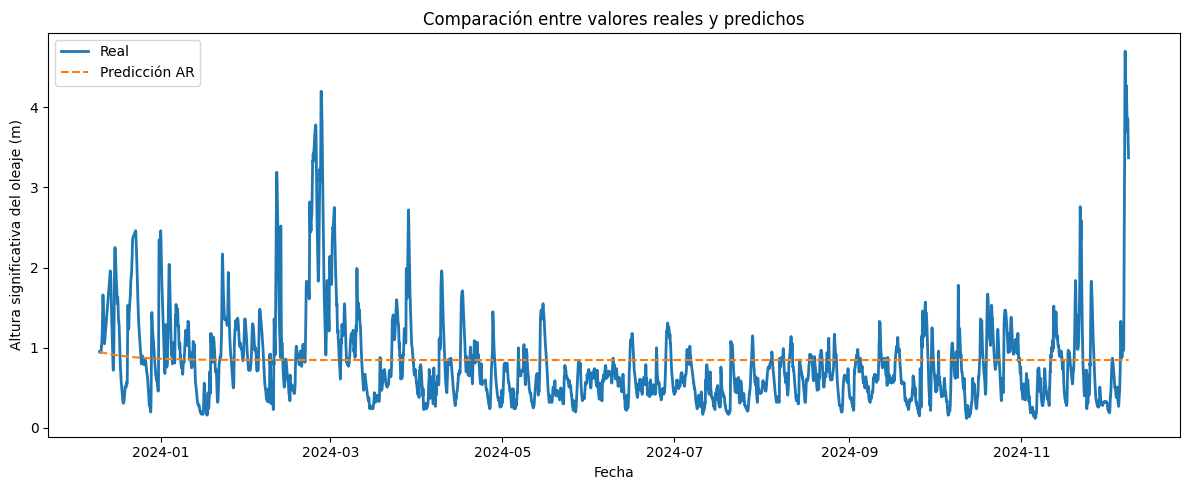

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Definimos el inicio y fin del rango de predicción
inicio = serie_prueba.index[0]
fin = serie_prueba.index[-1]

# Predecimos usando el modelo AR entrenado
predicciones = modelo_entrenado.predict(start=inicio, end=fin, dynamic=False)

# Aseguramos que ambos vectores estén alineados
predicciones = predicciones[:len(serie_prueba)]
serie_real = serie_prueba[:len(predicciones)]

# Cálculo de métricas
mse = mean_squared_error(serie_real, predicciones)
rmse = np.sqrt(mse)
r2 = r2_score(serie_real, predicciones)
mae = mean_absolute_error(serie_real, predicciones)

# MAPE requiere evitar divisiones por cero
mape = np.mean(np.abs((serie_real - predicciones) / serie_real)) * 100

# Mostrar resultados
print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


# Visualización
plt.figure(figsize=(12, 5))
plt.plot(serie_real.index, serie_real, label='Real', linewidth=2)
plt.plot(predicciones.index, predicciones, label='Predicción AR', linestyle='--')
plt.title('Comparación entre valores reales y predichos')
plt.xlabel('Fecha')
plt.ylabel('Altura significativa del oleaje (m)')
plt.legend()
plt.tight_layout()
plt.show()


# Modelo de medias móviles (MA)

Se implementa un modelo de media móvil (MA), que predice los valores futuros en función de los errores pasados. Para encontrar el mejor orden del modelo (valor de `q`), se prueba una serie de modelos con diferentes órdenes y se selecciona el que tenga el AIC más bajo. Este enfoque garantiza que el modelo tenga un buen equilibrio entre ajuste y complejidad.

In [ ]:
# Usamos solo las últimas 5000 observaciones (alrededor de medio año) para acelerar
serie_entrenamiento_sample = serie_entrenamiento[-5000:]

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

class MovingAverageRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, q=1):
        self.q = q

    def fit(self, X, y=None):
        self.model_ = ARIMA(X, order=(0, 0, self.q), enforce_invertibility=False).fit()
        self.X_train_ = X
        return self

    def predict(self, X):
        start = len(self.X_train_)
        end = start + len(X) - 1
        return self.model_.predict(start=start, end=end)

    def score(self, X, y):
        pred = self.predict(X)
        return -mean_squared_error(y, pred)


In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Crear modelo
ma_model = MovingAverageRegressor()

# Definir rango de q a probar
param_grid = {'q': list(range(1, 11))}

# Validación cruzada temporal
tscv = TimeSeriesSplit(n_splits=3)

# Ejecutar grid search
grid = GridSearchCV(ma_model, param_grid, scoring='neg_mean_squared_error', cv=tscv)

# Fit con los datos (X = y = la serie, porque es autoregresiva)
grid.fit(serie_entrenamiento_sample.to_numpy(), serie_entrenamiento_sample.to_numpy())

# Obtener el mejor modelo
mejor_q = grid.best_params_['q']
modelo_entrenado = ARIMA(serie_entrenamiento, order=(0, 0, mejor_q)).fit()

print(f"Mejor q encontrado: {mejor_q}")


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Mejor q encontrado: 7


Se evaluaron varios modelos MA con distintos valores de `q` usando una muestra reducida para acelerar el proceso. El modelo MA(7) fue el mejor que convergió correctamente

MSE : 0.3113
RMSE: 0.5579
R²  : 0.0000
MAE : 0.3955
MAPE: 70.61%


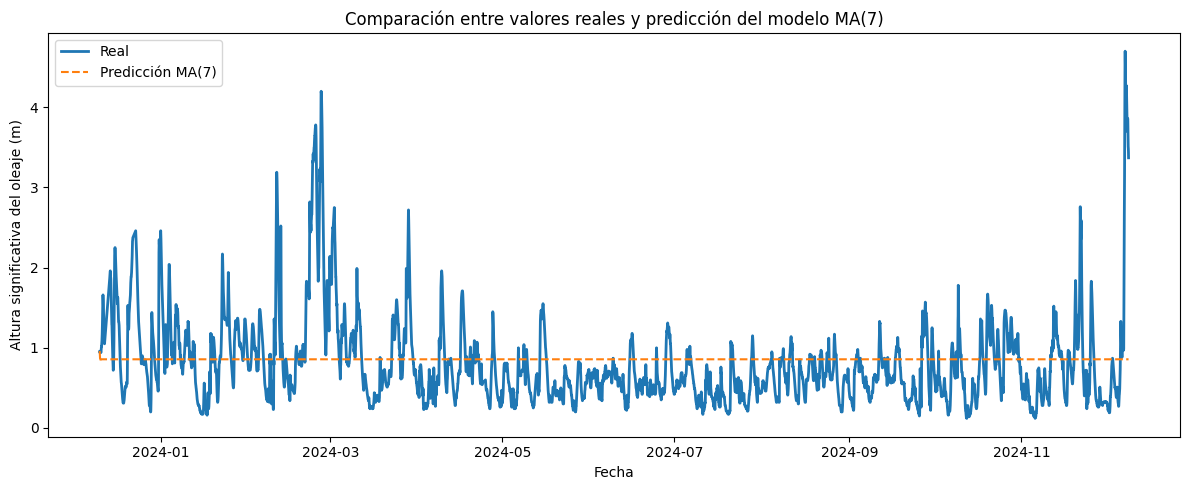

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Definimos el rango de predicción (igual que en AR)
inicio = serie_prueba.index[0]
fin = serie_prueba.index[-1]

# Generar predicciones
predicciones_ma = modelo_entrenado.predict(start=inicio, end=fin, dynamic=False)

# Alineamos predicción con los datos reales
predicciones_ma = predicciones_ma[:len(serie_prueba)]
reales_ma = serie_prueba[:len(predicciones_ma)]


mse = mean_squared_error(reales_ma, predicciones_ma)
rmse = np.sqrt(mse)
r2 = r2_score(reales_ma, predicciones_ma)
mae = mean_absolute_error(reales_ma, predicciones_ma)
mape = np.mean(np.abs((reales_ma - predicciones_ma) / reales_ma)) * 100

if (r2<0):
    r2=0;


print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


plt.figure(figsize=(12, 5))
plt.plot(reales_ma.index, reales_ma, label='Real', linewidth=2)
plt.plot(predicciones_ma.index, predicciones_ma, label='Predicción MA(7)', linestyle='--')
plt.title('Comparación entre valores reales y predicción del modelo MA(7)')
plt.xlabel('Fecha')
plt.ylabel('Altura significativa del oleaje (m)')
plt.legend()
plt.tight_layout()
plt.show()


# ARIMA

Se utiliza una muestra reducida del conjunto de entrenamiento (últimos 5.000 datos) para buscar automáticamente el mejor modelo ARIMA. Se evalúan distintas combinaciones de parámetros `p`, `d` y `q`, seleccionando el modelo que haya convergido correctamente y presente el menor valor de AIC.

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

class ARIMARegressor(BaseEstimator, RegressorMixin):
    def __init__(self, p=1, d=0, q=1):
        self.p = p
        self.d = d
        self.q = q

    def fit(self, X, y=None):
        self.model_ = ARIMA(X, order=(self.p, self.d, self.q),
                            enforce_invertibility=False).fit()
        self.X_train_ = X
        return self

    def predict(self, X):
        start = len(self.X_train_)
        end = start + len(X) - 1
        return self.model_.predict(start=start, end=end)

    def score(self, X, y):
        pred = self.predict(X)
        return -mean_squared_error(y, pred)


In [ ]:
# Usamos solo las últimas 5000 observaciones (alrededor de medio año) para acelerar
serie_entrenamiento_sample = serie_entrenamiento[-500:]

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {
    'p': range(0, 6),
    'd': range(0, 2),
    'q': range(0, 6)
}

tscv = TimeSeriesSplit(n_splits=3)
modelo = ARIMARegressor()

grid = GridSearchCV(modelo, param_grid, scoring='neg_mean_squared_error', cv=tscv)
grid.fit(serie_entrenamiento_sample.to_numpy(), serie_entrenamiento_sample.to_numpy())

# Modelo final
mejor_modelo = grid.best_estimator_
modelo_entrenado = ARIMA(
    serie_entrenamiento,
    order=(mejor_modelo.p, mejor_modelo.d, mejor_modelo.q)
).fit()

print(f"Mejor ARIMA: (p={mejor_modelo.p}, d={mejor_modelo.d}, q={mejor_modelo.q})")


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary s

Mejor ARIMA: (p=3, d=0, q=3)


MSE : 0.3111
RMSE: 0.5577
R²  : 0.0000
MAE : 0.3952
MAPE: 70.57%


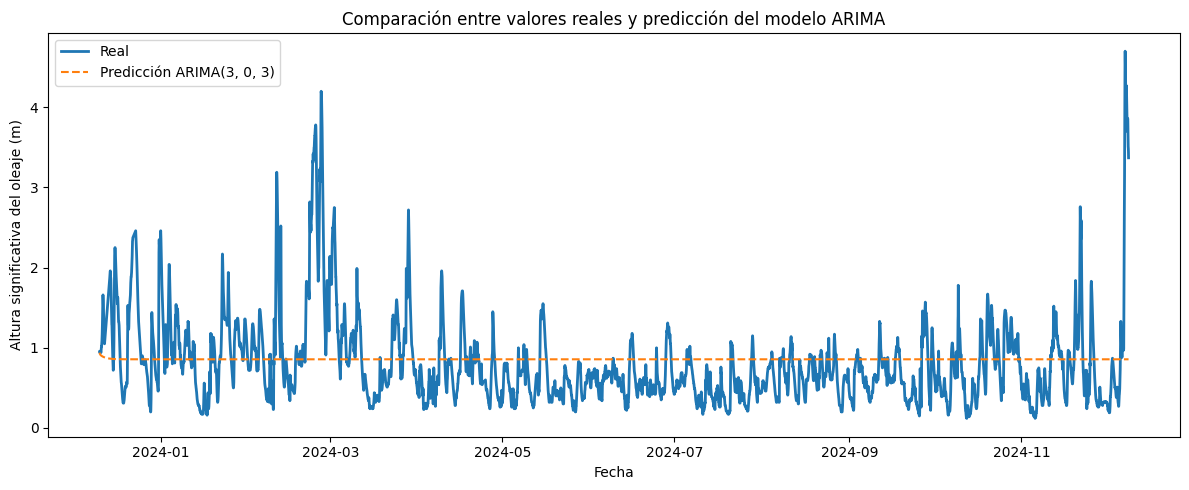

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# PREDICCIÓN CON MODELO ARIMA

# Rango de predicción
inicio = serie_prueba.index[0]
fin = serie_prueba.index[-1]

# Generar predicción
modelo_arima = modelo_entrenado
predicciones_arima = modelo_arima.predict(start=inicio, end=fin, dynamic=False)

# Alinear longitudes
predicciones_arima = predicciones_arima[:len(serie_prueba)]
reales_arima = serie_prueba[:len(predicciones_arima)]

# MÉTRICAS DE EVALUACIÓN

mse = mean_squared_error(reales_arima, predicciones_arima)
rmse = np.sqrt(mse)
r2 = r2_score(reales_arima, predicciones_arima)
mae = mean_absolute_error(reales_arima, predicciones_arima)
mape = np.mean(np.abs((reales_arima - predicciones_arima) / reales_arima)) * 100

if (r2<0):
    r2=0;

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# VISUALIZACIÓN

plt.figure(figsize=(12, 5))
plt.plot(reales_arima.index, reales_arima, label='Real', linewidth=2)
plt.plot(predicciones_arima.index, predicciones_arima, label=f'Predicción ARIMA{mejor_modelo.p, mejor_modelo.d, mejor_modelo.q}', linestyle='--')
plt.title('Comparación entre valores reales y predicción del modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Altura significativa del oleaje (m)')
plt.legend()
plt.tight_layout()
plt.show()


# ARIMAX

Se genera un mapa de correlación entre las variables numéricas del dataset para identificar aquellas que tienen mayor relación lineal con la variable objetivo: `AlturaSignif.delOleaje(m)`.
Este análisis permite seleccionar las variables exógenas más relevantes para el modelo ARIMAX, evitando introducir ruido innecesario.

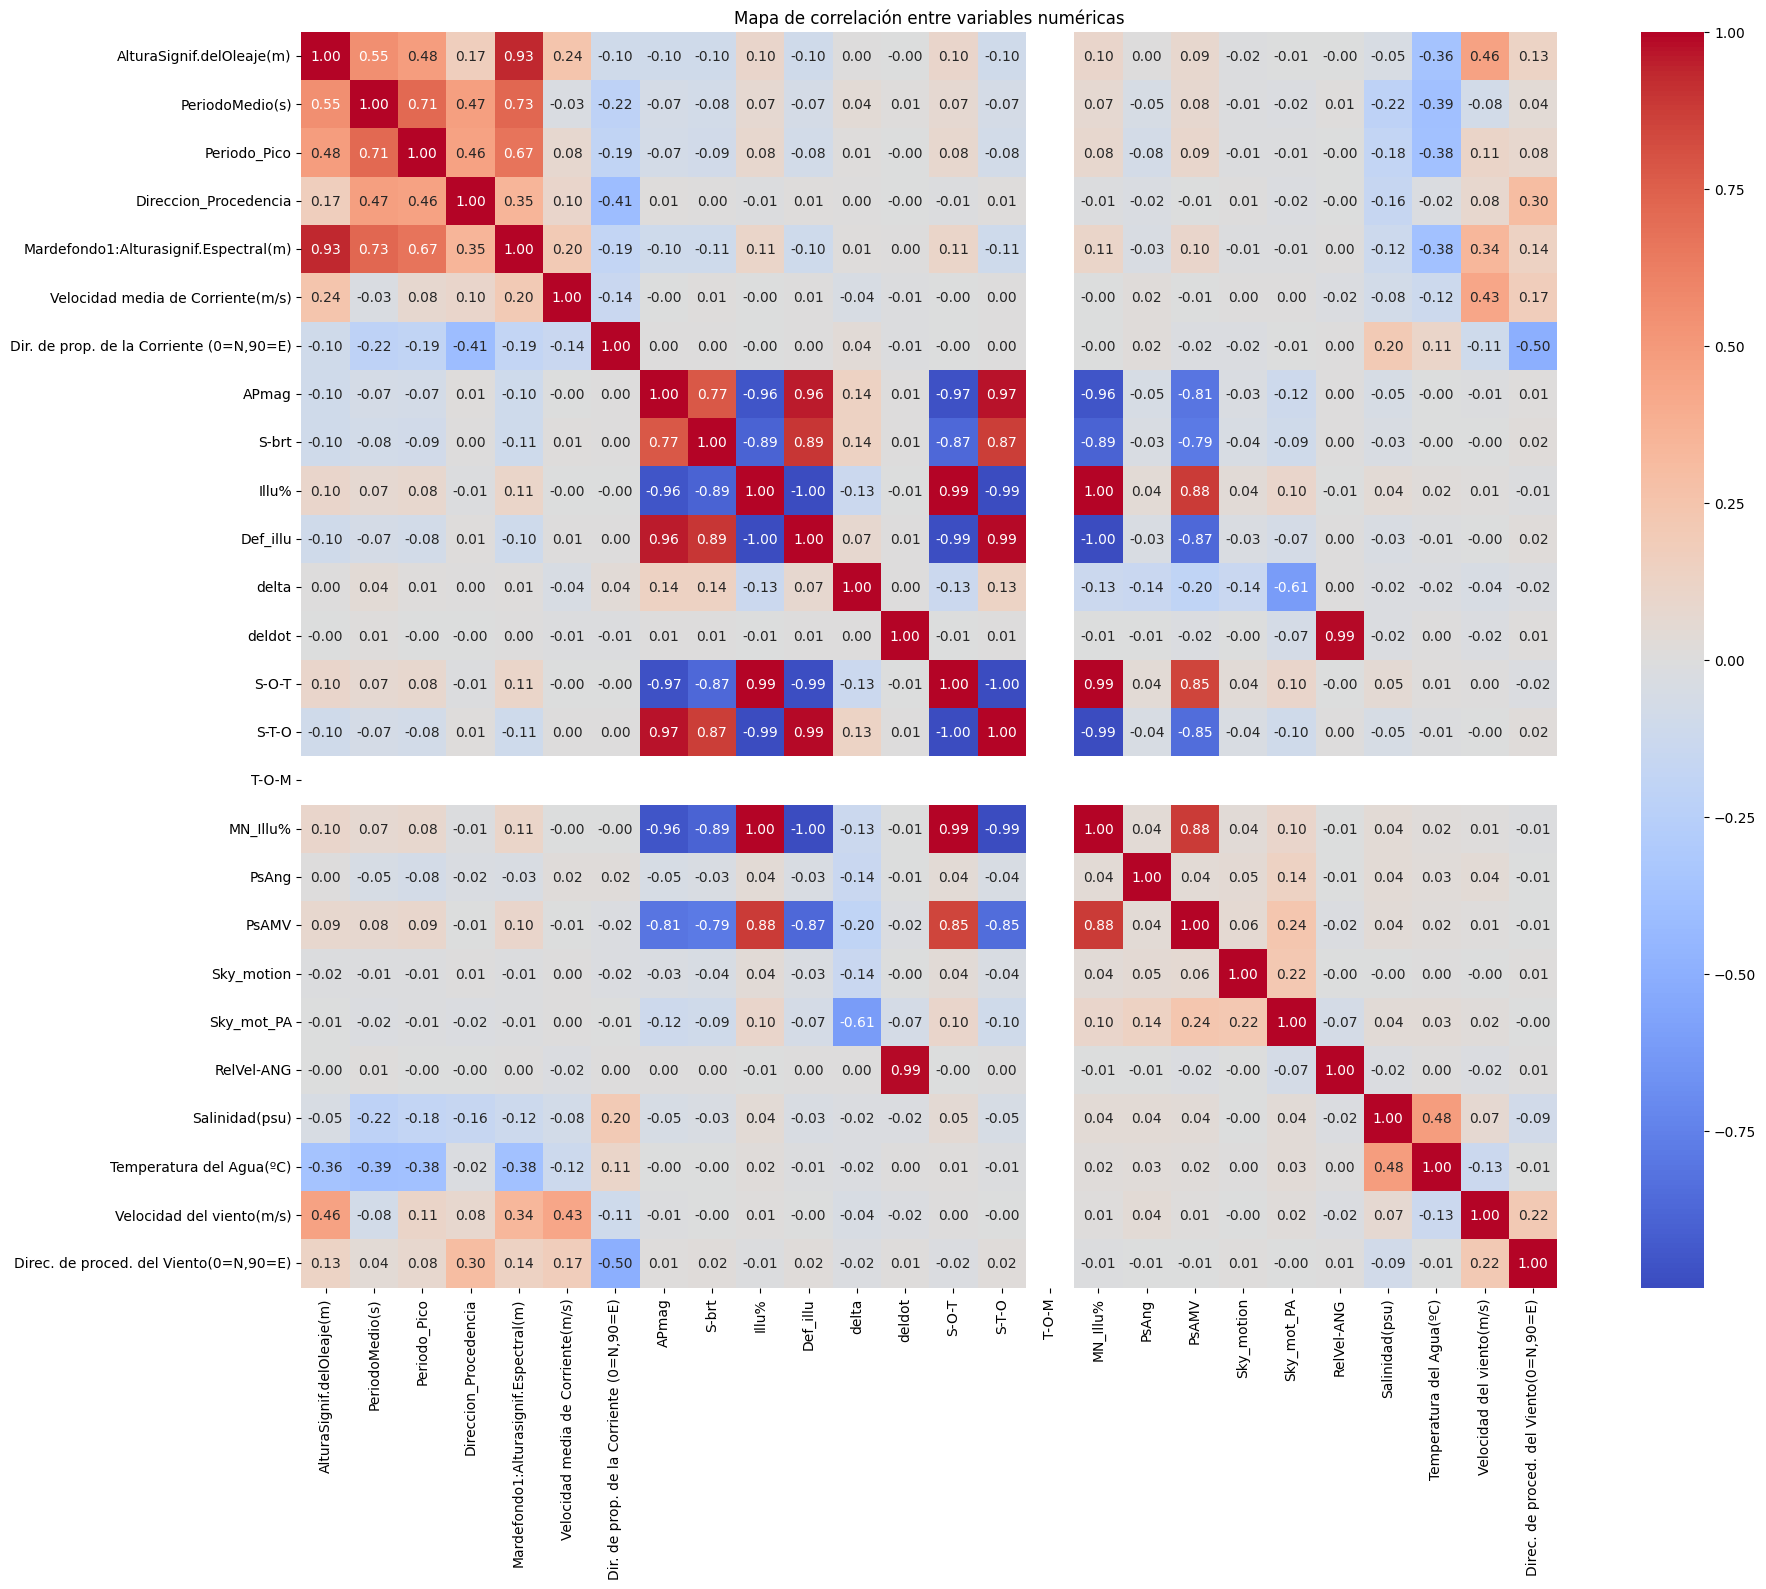

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# MAPA DE CORRELACIÓN

# Calculamos la matriz de correlación
correlaciones = df.corr(numeric_only=True)

# Dibujamos el heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlaciones, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Mapa de correlación entre variables numéricas")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Calcular matriz de correlación (solo variables numéricas)
correlaciones = df.corr(numeric_only=True)

# Extraer y ordenar correlación respecto a la variable objetivo
objetivo = 'AlturaSignif.delOleaje(m)'
correlacion_objetivo = correlaciones[[objetivo]].sort_values(by=objetivo, ascending=False)

# Mostrar lista ordenada
print("Correlación con la variable objetivo:")
print(correlacion_objetivo)


Correlación con la variable objetivo:
                                          AlturaSignif.delOleaje(m)
AlturaSignif.delOleaje(m)                                  1.000000
Mardefondo1:Alturasignif.Espectral(m)                      0.927804
PeriodoMedio(s)                                            0.526225
Periodo_Pico                                               0.458684
Velocidad del viento(m/s)                                  0.436376
Velocidad media de Corriente(m/s)                          0.201039
Direccion_Procedencia                                      0.164276
Direc. de proced. del Viento(0=N,90=E)                     0.134987
MN_Illu%                                                   0.090391
Illu%                                                      0.090391
S-O-T                                                      0.087298
PsAMV                                                      0.086845
PsAng                                                      0.017967
Sky_mot_PA

A partir de esto selecionamos las variables exógenas para el modelo ARIMAX


In [ ]:
exog_cols = [
    'Mardefondo1:Alturasignif.Espectral(m)'
]

# Subconjuntos de exógenas
exog_entrenamiento = df[exog_cols].loc[serie_entrenamiento.index]
exog_prueba = df[exog_cols].loc[serie_prueba.index]


utilizamos los mejores parámetros que buscamos previamente para el ARIMA

In [ ]:
orden = (3, 0, 3)

from statsmodels.tsa.arima.model import ARIMA

# Entrenar modelo ARIMAX
modelo_arimax = ARIMA(
    serie_entrenamiento,
    order=orden,
    exog=exog_entrenamiento
).fit()

# PREDICCIÓN Y EVALUACIÓN

# Generar predicciones
predicciones_arimax = modelo_arimax.predict(
    start=serie_prueba.index[0],
    end=serie_prueba.index[-1],
    exog=exog_prueba,
    dynamic=False
)

# Alinear predicción y reales
predicciones_arimax = predicciones_arimax[:len(serie_prueba)]
reales_arimax = serie_prueba[:len(predicciones_arimax)]

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(reales_arimax, predicciones_arimax)
rmse = np.sqrt(mse)
r2 = r2_score(reales_arimax, predicciones_arimax)
mae = mean_absolute_error(reales_arimax, predicciones_arimax)
mape = np.mean(np.abs((reales_arimax - predicciones_arimax) / reales_arimax)) * 100

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# VISUALIZACIÓN

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(reales_arimax.index, reales_arimax, label='Real', linewidth=2)
plt.plot(predicciones_arimax.index, predicciones_arimax, label='Predicción ARIMAX', linestyle='--')
plt.title(f'Predicción con modelo ARIMAX{orden}')
plt.xlabel('Fecha')
plt.ylabel('Altura significativa del oleaje (m)')
plt.legend()
plt.tight_layout()
plt.show()

veamos si cogiendo más variables exógenas mejoramos aún más el modelo

In [ ]:
exog_cols = [
    'Mardefondo1:Alturasignif.Espectral(m)', "PeriodoMedio(s)"
]

# Subconjuntos de exógenas
exog_entrenamiento = df[exog_cols].loc[serie_entrenamiento.index]
exog_prueba = df[exog_cols].loc[serie_prueba.index]

MSE : 0.0300
RMSE: 0.1733
R²  : 0.9028
MAE : 0.1339
MAPE: 24.31%


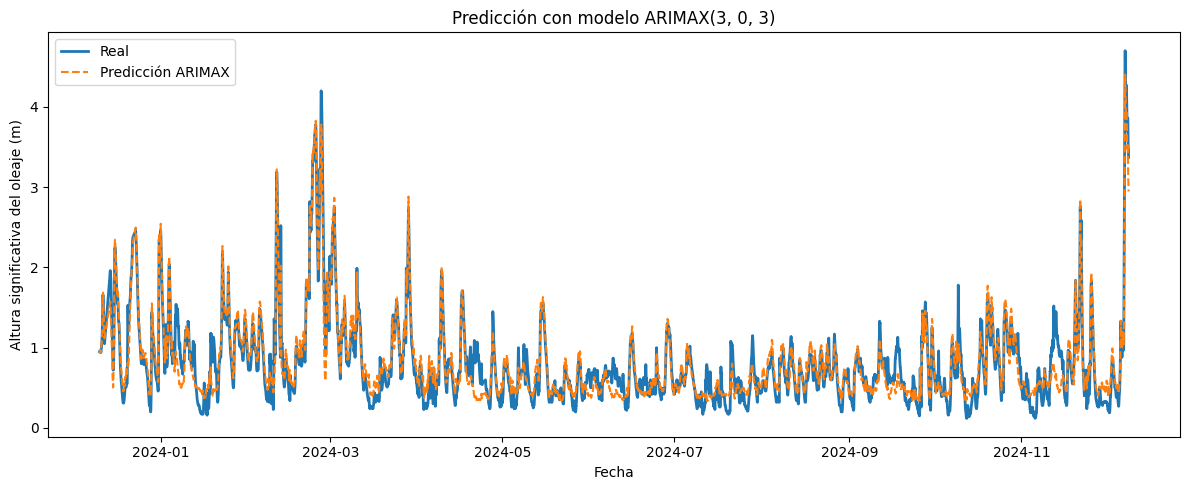

In [ ]:
orden = (3, 0, 3)
from statsmodels.tsa.arima.model import ARIMA

# Entrenar modelo ARIMAX
modelo_arimax = ARIMA(
    serie_entrenamiento,
    order=orden,
    exog=exog_entrenamiento
).fit()

# PREDICCIÓN Y EVALUACIÓN

# Generar predicciones
predicciones_arimax = modelo_arimax.predict(
    start=serie_prueba.index[0],
    end=serie_prueba.index[-1],
    exog=exog_prueba,
    dynamic=False
)

# Alinear predicción y reales
predicciones_arimax = predicciones_arimax[:len(serie_prueba)]
reales_arimax = serie_prueba[:len(predicciones_arimax)]

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(reales_arimax, predicciones_arimax)
rmse = np.sqrt(mse)
r2 = r2_score(reales_arimax, predicciones_arimax)
mae = mean_absolute_error(reales_arimax, predicciones_arimax)
mape = np.mean(np.abs((reales_arimax - predicciones_arimax) / reales_arimax)) * 100

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# VISUALIZACIÓN

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(reales_arimax.index, reales_arimax, label='Real', linewidth=2)
plt.plot(predicciones_arimax.index, predicciones_arimax, label='Predicción ARIMAX', linestyle='--')
plt.title(f'Predicción con modelo ARIMAX{orden}')
plt.xlabel('Fecha')
plt.ylabel('Altura significativa del oleaje (m)')
plt.legend()
plt.tight_layout()
plt.show()


vemos que ha mejorado, probemos con otra más

In [ ]:
exog_cols = [
    'Mardefondo1:Alturasignif.Espectral(m)', "PeriodoMedio(s)", "Periodo_Pico"
]

# Subconjuntos de exógenas
exog_entrenamiento = df[exog_cols].loc[serie_entrenamiento.index]
exog_prueba = df[exog_cols].loc[serie_prueba.index]

MSE : 0.0313
RMSE: 0.1768
R²  : 0.8988
MAE : 0.1442
MAPE: 27.14%


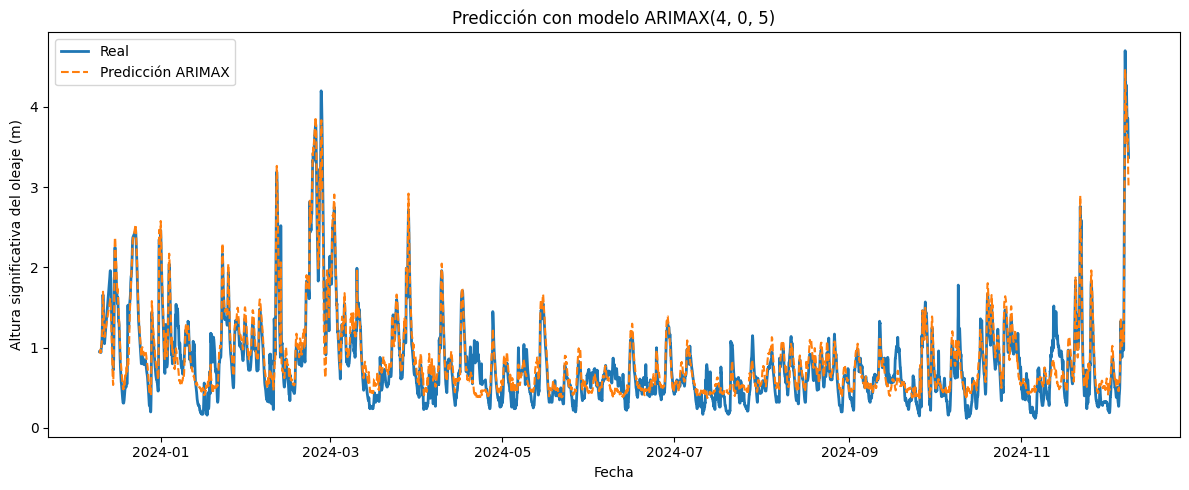

In [ ]:
orden = (3, 0, 3)

from statsmodels.tsa.arima.model import ARIMA

# Entrenar modelo ARIMAX
modelo_arimax = ARIMA(
    serie_entrenamiento,
    order=orden,
    exog=exog_entrenamiento
).fit()

# PREDICCIÓN Y EVALUACIÓN

# Generar predicciones
predicciones_arimax = modelo_arimax.predict(
    start=serie_prueba.index[0],
    end=serie_prueba.index[-1],
    exog=exog_prueba,
    dynamic=False
)

# Alinear predicción y reales
predicciones_arimax = predicciones_arimax[:len(serie_prueba)]
reales_arimax = serie_prueba[:len(predicciones_arimax)]

# Métricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(reales_arimax, predicciones_arimax)
rmse = np.sqrt(mse)
r2 = r2_score(reales_arimax, predicciones_arimax)
mae = mean_absolute_error(reales_arimax, predicciones_arimax)
mape = np.mean(np.abs((reales_arimax - predicciones_arimax) / reales_arimax)) * 100

print(f"MSE : {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

# VISUALIZACIÓN

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(reales_arimax.index, reales_arimax, label='Real', linewidth=2)
plt.plot(predicciones_arimax.index, predicciones_arimax, label='Predicción ARIMAX', linestyle='--')
plt.title(f'Predicción con modelo ARIMAX{orden}')
plt.xlabel('Fecha')
plt.ylabel('Altura significativa del oleaje (m)')
plt.legend()
plt.tight_layout()
plt.show()


como vemos que el modelo ha disminuido su r2, nos quedamos con las variables exógenas de mar de fondo y pico medio



el mejor modelo es ARIMAX con las variables exógenas de mar de fondo y periodo pico